# Loading rh outputs and defining various constants

In [1]:
#%matplotlib inline
#%matplotlib widget
#%matplotlib ipympl
from helita.sim import rh15d
from helita.vis import rh15d_vis
import numpy as np
import matplotlib.pyplot as plt



# rest frame h and k line in air (https://iris.lmsal.com/itn39/Mg_diagnostics.html)
wl_k_rest = 1e7/35760.875   # from MgII-IRIS.atom
wl_h_rest = 1e7/35669.312   # from MgII-IRIS.atom


#path = "./column_1/"    # rh runned on 64 columns around [x,y] = [757,380] (feature in the magnetic field at z approx 0)
path = "./single_column_1/"       # as above but with only one column [757,380]
col_idx = [0,0]

try:
    data.close()
except:
    pass

data = rh15d.Rh15dout(path)

--- Read ./single_column_1/output_aux.hdf5 file.
--- Read ./single_column_1/output_indata.hdf5 file.
--- Read ./single_column_1/output_ray.hdf5 file.


/mn/stornext/u3/jonastf/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:40: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  setattr(self, g, xr.open_dataset(infile, group=g, autoclose=True))
/mn/stornext/u3/jonastf/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:53: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  self.ray = xr.open_dataset(infile, autoclose=True)


# Attributes in datafile

In [2]:
print("-------------------------------------------------------------------------------------\n")
for i, files in enumerate(data.files):
    print("data.files[%i]" % i)
    print(files,"\n\n-------------------------------------------------------------------------------------\n")

-------------------------------------------------------------------------------------

data.files[0]
<xarray.Dataset>
Dimensions:          (height: 1024, level: 11, phony_dim_4: 10, phony_dim_5: 15, x: 1, y: 1)
Coordinates:
  * x                (x) float64 8.867e+06
  * y                (y) float64 -4.451e+06
Dimensions without coordinates: height, level, phony_dim_4, phony_dim_5
Data variables:
    continuum        (phony_dim_4) uint32 ...
    line             (phony_dim_5) uint32 ...
    populations      (level, x, y, height) float32 ...
    populations_LTE  (level, x, y, height) float32 ...
Attributes:
    nlevel:      11
    nline:       15
    ncontinuum:  10 

-------------------------------------------------------------------------------------

data.files[1]
<xarray.Dataset>
Dimensions:            (element: 99, height: 1024, ray: 5, x: 1, y: 1)
Coordinates:
  * x                  (x) float64 8.867e+06
  * y                  (y) float64 -4.451e+06
Dimensions without coordinates: 

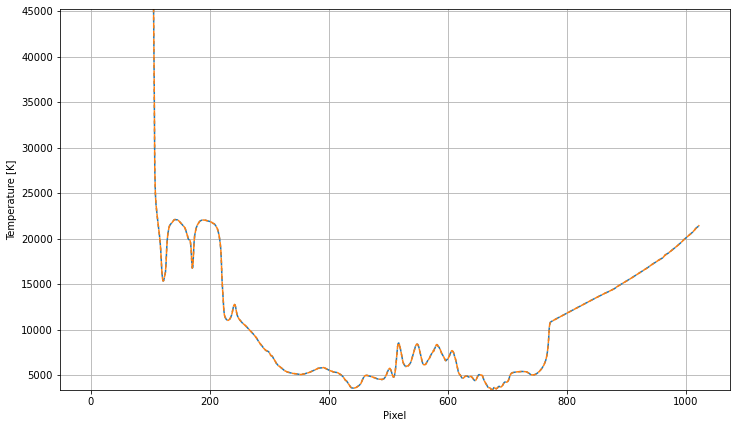

In [3]:
import h5py
file_path = "../../../Atmos/bifrost_ch012012_hion_snap800.hdf5"
file = h5py.File(file_path, "r")

plt.figure(figsize=(12,7))
rh_temp = data.atmos.temperature[col_idx[0], col_idx[1]]
atmos_file_temp = file["temperature"][0,757,380,:]

# To check if the indices from atmosphere file matches the indices used in rh code
plt.plot(rh_temp, "--")
plt.plot(atmos_file_temp, "--")
plt.ylim(np.min(rh_temp), np.max(rh_temp));
plt.xlabel("Pixel")
plt.ylabel("Temperature [K]")
plt.grid()


We see that the curves matches perfectly. The match is done so that we know rh is computed on the right column in the atmosphere file.

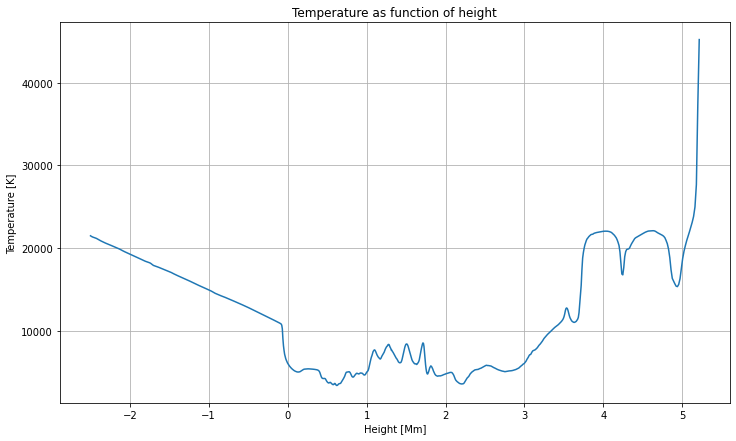

In [4]:
height = data.files[1].height_scale[col_idx[0], col_idx[1]]

plt.figure(figsize=(12,7))
plt.plot(height*1e-6, atmos_file_temp)
plt.xlabel("Height [Mm]"); plt.ylabel("Temperature [K]")
plt.title("Temperature as function of height")
plt.grid()

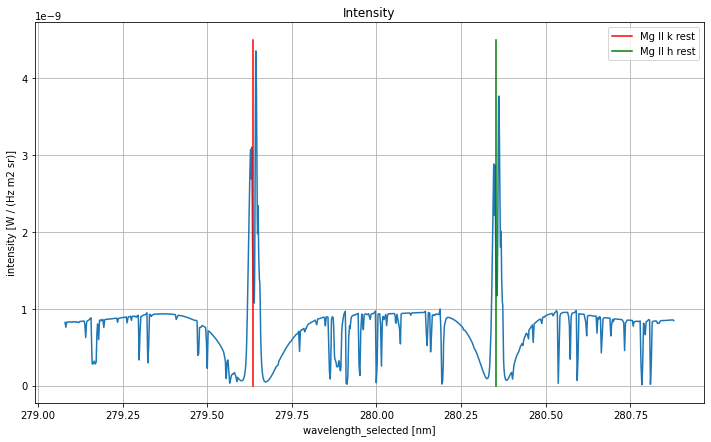

In [5]:
plt.figure(figsize=(12,7))

wave = data.ray.wavelength
vac = 0.08       # used if VACUUM_TO_AIR = FALSE in keyword.input (just set 0 if TRUE)
min_wave, max_wave = 279+vac, 280.8+vac
#indices = np.arange(len(wave))[(wave > min_wave) & (wave < max_wave)]      # want to add these indices to ray.input
indices = data.files[4].wavelength_indices       # no using these indices instead
data.ray.intensity[col_idx[0], col_idx[1]][indices].plot()
plt.plot([wl_k_rest, wl_k_rest], [0, 4.5e-9], label="Mg II k rest", color="Red")
plt.plot([wl_h_rest, wl_h_rest], [0, 4.5e-9], label="Mg II h rest", color="Green")
plt.title("Intensity")
plt.grid()
plt.legend();
#data.ray.intensity[col_idx[0], col_idx[1]].plot()      # plot all of the intensity spectrum
#plt.plot(wave[indices], data.ray.intensity[col_idx[0], col_idx[1]][indices], ".")   # plot intensity with points

# Adding specific indices in `ray.input` and rerun rh for detailed outputs
Remember to move `ray.input` into the correct folder (from /run_project/output to /run_project) before rerun.

In [6]:
f = open("ray.input", "w")  # this will overwrite any existing file!
f.write("1.00\n")
output = str(len(indices))
for ind in indices:
    output += " %i" % ind
f.write(output)
f.close()

In [7]:
mg_k = [279.5+vac, 279.6+vac]
mg_h = [280.22+vac, 280.32+vac]     
idx_k = np.arange(len(wave))[(wave > mg_k[0]) & (wave < mg_k[1])]
idx_h = np.arange(len(wave))[(wave > mg_h[0]) & (wave < mg_h[1])]

I_k = data.ray.intensity[col_idx[0], col_idx[1]][idx_k]
I_h = data.ray.intensity[col_idx[0], col_idx[1]][idx_h]

wave_k = wave[idx_k]
idx_k_center = np.where(np.min(abs(wave_k-wl_k_rest)) == abs(wave_k-wl_k_rest))[0]

while True:
    I_r = I_k[idx_k_center+1][0]     # right of temporary center
    I_l = I_k[idx_k_center-1][0]     # left of temporary center
    
    if I_r < I_k[idx_k_center]:
        idx_k_center += 1
    elif I_l < I_k[idx_k_center]:
        idx_k_center -= 1
    else:
        break

wl_k_center = wave_k[idx_k_center][0]


wave_h = wave[idx_h]
idx_h_center = np.where(np.min(abs(wave_h-wl_h_rest)) == abs(wave_h-wl_h_rest))[0]

while True:
    I_r = I_h[idx_h_center+1][0]     # right of temporary center
    I_l = I_h[idx_h_center-1][0]     # left of temporary center
    
    if I_r < I_h[idx_h_center]:
        idx_h_center += 1
    elif I_l < I_h[idx_h_center]:
        idx_h_center -= 1
    else:
        break

wl_h_center = wave_h[idx_h_center][0]

Doppler shift in Mg II k: 0.00294 nm
Doppler shift in Mg II h: 0.00252 nm


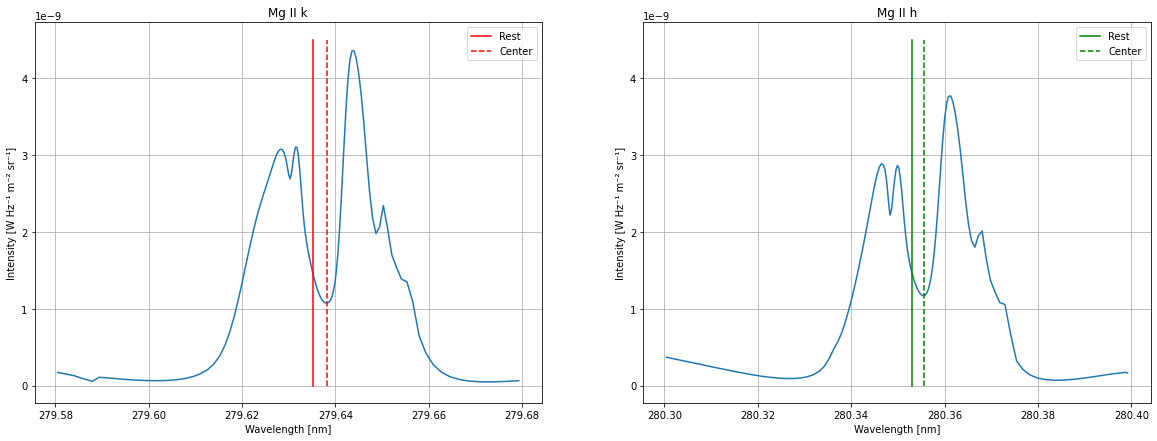

In [8]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(wave[idx_k], I_k)
plt.plot([wl_k_rest, wl_k_rest], [0, 4.5e-9], label="Rest", color="Red")
plt.plot([wl_k_center, wl_k_center], [0, 4.5e-9], "--", label="Center", color="Red")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [W Hz⁻¹ m⁻² sr⁻¹]")
plt.grid()
plt.legend()
plt.title("Mg II k")

plt.subplot(122)
plt.plot(wave[idx_h], I_h)
plt.plot([wl_h_rest, wl_h_rest], [0, 4.5e-9], label="Rest", color="Green")
plt.plot([wl_h_center, wl_h_center], [0, 4.5e-9], "--", label="Center", color="Green")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [W Hz⁻¹ m⁻² sr⁻¹]")
plt.grid()
plt.legend()
plt.title("Mg II h");

dwl_k = wl_k_center-wl_k_rest
dwl_h = wl_h_center-wl_h_rest
print("Doppler shift in Mg II k: %.5f nm" % dwl_k)
print("Doppler shift in Mg II h: %.5f nm" % dwl_h)

Converting wavelengths to $\Delta \nu$ [km/s] and replot.

In [22]:
from astropy import constants, units

c = constants.c.to("nm/s")
dnu_k = (wl_k_rest - wave_k) / wl_k_rest * c * 1e-12
dnu_h = (wl_h_rest - wave_h) / wl_h_rest * c * 1e-12
dnu_k_center = (wl_k_rest - wl_k_center) / wl_k_rest * c * 1e-12
dnu_h_center = (wl_h_rest - wl_h_center) / wl_h_rest * c * 1e-12

dnu_lim = 45
dnu_k_lim_idx = np.where(abs(dnu_k<dnu_lim))
dnu_h_lim_idx = np.where(abs(dnu_h<dnu_lim))

dnu_k = dnu_k[dnu_k_lim_idx]
I_dnu_k = I_k[dnu_k_lim_idx]
dnu_h = dnu_h[np.where(abs(dnu_h<dnu_lim))]
I_dnu_h = I_h[dnu_h_lim_idx]

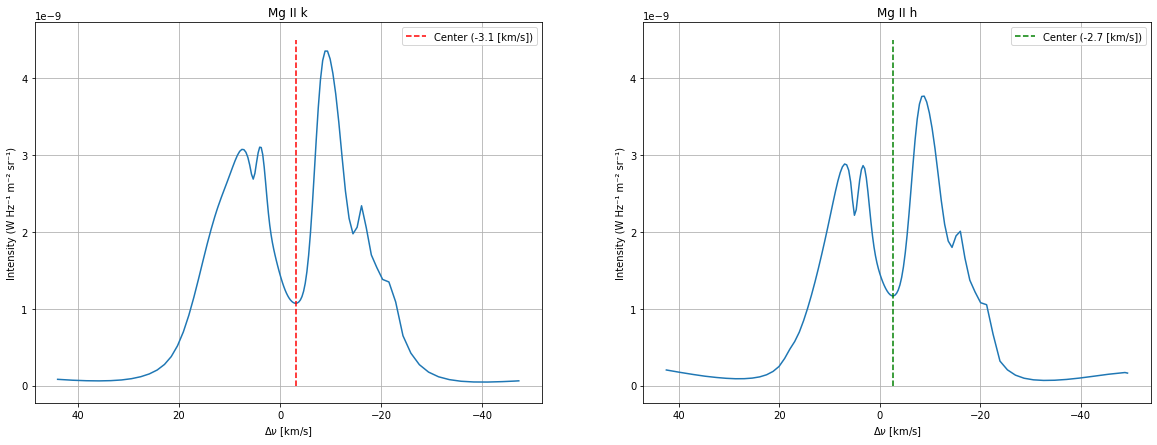

In [24]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7))
ax1.plot(dnu_k, I_dnu_k)
ax1.plot([dnu_k_center, dnu_k_center], [0, 4.5e-9], "--", label="Center (%.1f [km/s])" % dnu_k_center, color="Red")
ax1.set_xlabel(r"$\Delta \nu$ [km/s]")
ax1.set_ylabel("Intensity (W Hz⁻¹ m⁻² sr⁻¹)")
ax1.invert_xaxis()
ax1.grid()
ax1.legend()
ax1.set_title("Mg II k")


ax2.plot(dnu_h, I_dnu_h)
ax2.plot([dnu_h_center, dnu_h_center], [0, 4.5e-9], "--", label="Center (%.1f [km/s])" % dnu_h_center, color="Green")
ax2.set_xlabel(r"$\Delta \nu$ [km/s]")
ax2.set_ylabel("Intensity (W Hz⁻¹ m⁻² sr⁻¹)")
ax2.invert_xaxis()
ax2.grid()
ax2.legend()
ax2.set_title("Mg II h");

# Source function

Widget did not work properly

In [71]:
sf = data.files[4].source_function[col_idx[0], col_idx[1]]
sf_tau_one_height = np.zeros(len(indices))

tau_one_height = data.files[4].tau_one_height[col_idx[0], col_idx[1]]

for i,idx in enumerate(indices):
    idx_temp = np.where(abs(height-tau_one_height[idx]) == np.min(abs(height-tau_one_height[idx])))[0]
    sf_tau_one_height[i] = sf[idx_temp, i]

(1024, 942)
(942,)


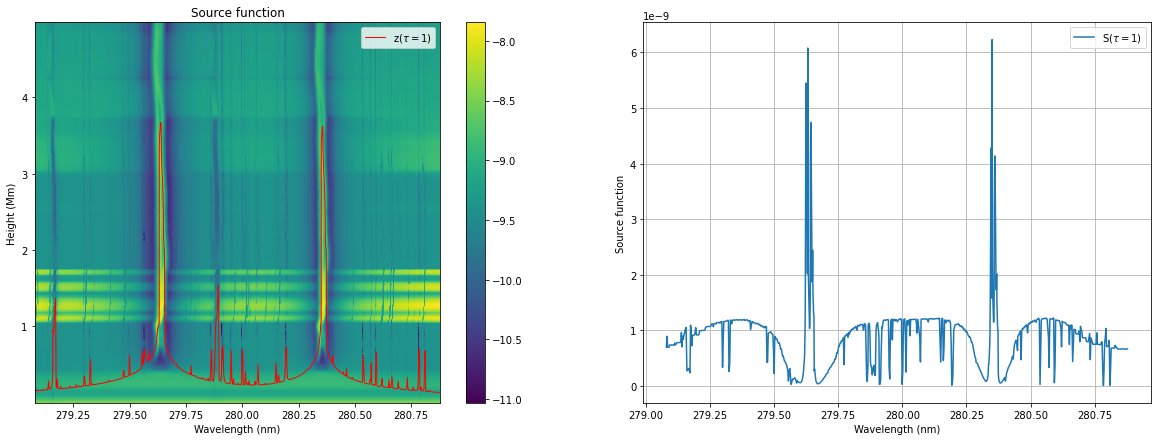

In [79]:
from pylab import pcolormesh

to_idx = np.where(abs(height) == np.min(abs(height)))[0][0]
from_idx = 120

plt.figure(figsize=(20,7))
plt.subplot(121)
pcolormesh(wave[indices], height[from_idx:to_idx]*1e-6, np.log10(sf[from_idx:to_idx,:]), shading="auto")
plt.plot(wave[indices], tau_one_height[indices]*1e-6, color="red", label=r"z($\tau=1$)", lw=1)
plt.title("Source function")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Height [Mm]")
plt.colorbar()
plt.legend()



plt.subplot(122)
plt.plot(wave[indices], sf_tau_one_height, label=r"S($\tau=1$)")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Source function")
plt.grid()
plt.legend();

Getting source function at $\tau=1$

# Study of parameters at optical depth $\tau = 1$ at the chosen region in the atmosphere

The optical depth is stored as we have 15D_WRITE_TAU1 = TRUE in the `keyword.input` file and is stored in the `output_ray.hdf5` file.

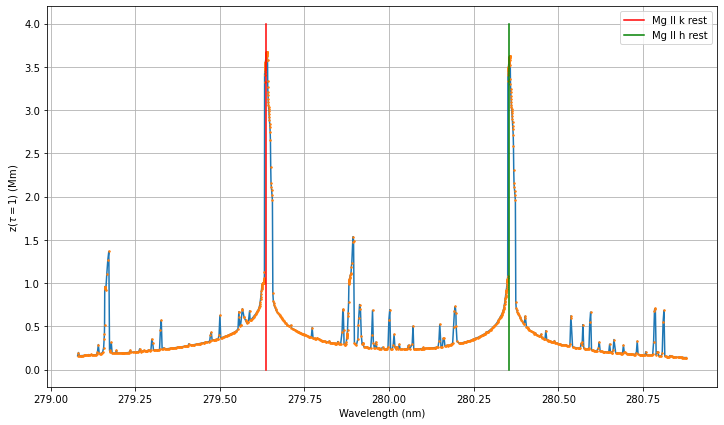

In [51]:
#tau_one_shape = tau_one_height.shape
plt.figure(figsize=(12,7))
#for i in range(tau_one_shape[0]):
#    for j in range(tau_one_shape[1]):
#        plt.plot(wave, tau_one[i,j,:]*1e-6)#, label="column = [%i,%i]" % (X[i], Y[j]))

#plt.plot(wave[indices], tau_one[0,0,indices]*1e-6)#, label="column = [%i,%i]" % (X[i], Y[j]))
plt.plot(wave[indices], tau_one_height[col_idx[0], col_idx[1],indices]*1e-6)#, label="column = [%i,%i]" % (X[i], Y[j]))
plt.plot(wave[indices], tau_one_height[col_idx[0], col_idx[1],indices]*1e-6, ".", ms=3)#, label="column = [%i,%i]" % (X[i], Y[j]))
plt.plot([wl_k_rest, wl_k_rest], [0, 4], label="Mg II k rest", color="Red")
plt.plot([wl_h_rest, wl_h_rest], [0, 4], label="Mg II h rest", color="Green")
plt.xlabel("Wavelength [nm]")
plt.ylabel(r"z($\tau=1$) [Mm]")
plt.grid()
plt.legend()
plt.show()
        

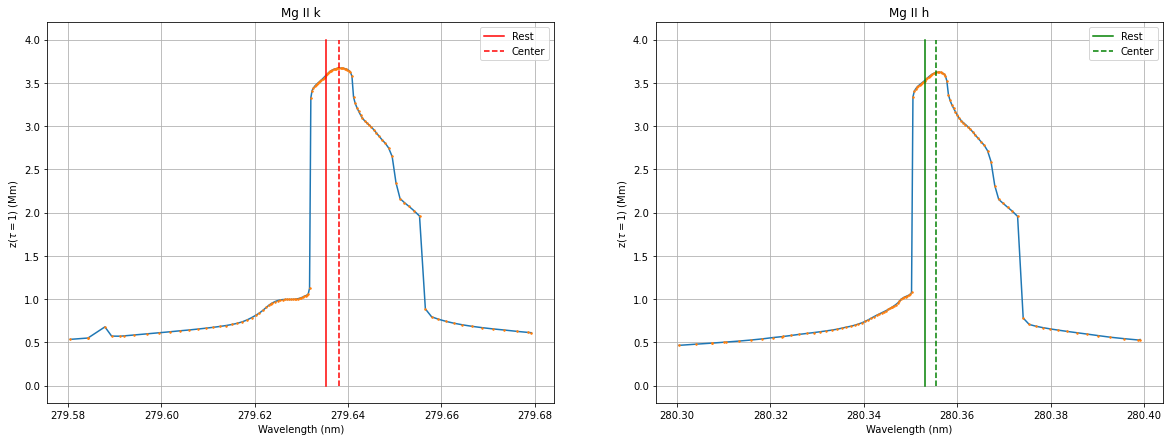

In [52]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(wave_k, tau_one_height[col_idx[0], col_idx[1], idx_k]*1e-6)#, label="column = [%i,%i]" % (X[i], Y[j]))
plt.plot(wave_k, tau_one_height[col_idx[0], col_idx[1], idx_k]*1e-6, ".", ms=3)#, label="column = [%i,%i]" % (X[i], Y[j]))
plt.plot([wl_k_rest, wl_k_rest], [0, 4], label="Rest", color="Red")
plt.plot([wl_k_center, wl_k_center], [0, 4], "--", label="Center", color="Red")
plt.xlabel("Wavelength [nm]")
plt.ylabel(r"z($\tau=1$) [Mm]")
plt.grid()
plt.legend()
plt.title("Mg II k")

plt.subplot(122)
plt.plot(wave_h, tau_one_height[col_idx[0], col_idx[1], idx_h]*1e-6)#, label="column = [%i,%i]" % (X[i], Y[j]))
plt.plot(wave_h, tau_one_height[col_idx[0], col_idx[1], idx_h]*1e-6, ".", ms=3)#, label="column = [%i,%i]" % (X[i], Y[j]))
plt.plot([wl_h_rest, wl_h_rest], [0, 4], label="Rest", color="Green")
plt.plot([wl_h_center, wl_h_center], [0, 4], "--", label="Center", color="Green")
plt.xlabel("Wavelength [nm]")
plt.ylabel(r"z($\tau=1$) [Mm]")
plt.grid()
plt.legend()
plt.title("Mg II h");


In [124]:
cont = data.files[0].continuum
line = data.files[0].line
pop = data.files[0].populations
pop_lte = data.files[0].populations_LTE

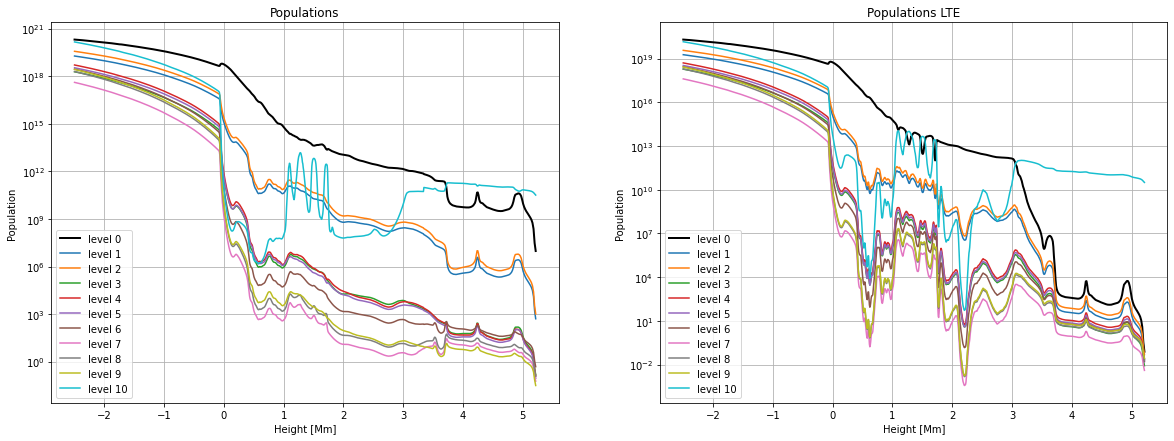

In [125]:
plt.figure(figsize=(20,7))

# first population
plt.subplot(121)
plt.title("Populations")
plt.plot(height*1e-6, pop[0,0,0,:], label="level 0", color="Black", lw=2)
# the rest of populations
for i in range(1, pop.shape[0]):
    plt.plot(height*1e-6, pop[i,0,0,:], label="level %i" % i)
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Height [Mm]")
plt.ylabel("Population")

# first population
plt.subplot(122)
plt.title("Populations LTE")
plt.plot(height*1e-6, pop_lte[0,0,0,:], label="level 0", color="Black", lw=2)
# the rest of populations
for i in range(1, pop.shape[0]):
    plt.plot(height*1e-6, pop_lte[i,0,0,:], label="level %i" % i)
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Height [Mm]")
plt.ylabel("Population");

# Terms and abbreviation

- Interface Region Imaging Spectrograph (IRIS)
- Local thermodynamic equilibrium (LTE)
- Partial frequency redistribution (PRD)
- Radiation-magnetohydrodynamic (RMHD)
- Complete redistribution (CRD)
- Transition region (TR)
- Joint probability density function (JPDF)
